In [1]:
# https://www.thispersondoesnotexist.com/
# ->  nvidia에서 GAN네트워크로 이미지 학습하여
# 가짜 이미지를 합성하는 것.  => 이미지 만들어 내는 것
# 위 페이지를 reload 할때마다, 다른 사람 얼굴이 나옴

In [2]:
# https://thebook.io/080228/part05/ch19/
# 생성적 적대 신경망(Generative Adversarial Networks), 
# 줄여서 ‘GAN(간)’이라고 부르는 알고리즘을 이용해 만든 것들
# GAN은 
# 딥러닝의 원리를 활용해 가상의 이미지를 생성하는 알고리즘입니다. 
# 예를 들어 얼굴을 만든다면, 
# 이미지 픽셀들이 어떻게 조합되어야 우리가 생각하는 ‘얼굴’의 형상이 되는지를 
# 딥러닝 알고리즘이 예측한 결과

In [3]:
# 가짜를 만들어 내는 파트를 ‘생성자(Generator)’,   ->  위조지폐 만드는 범죄자 
# 진위를 가려내는 파트를 ‘판별자(Discriminator)’   ->  판별하려는 경찰

In [4]:
# GAN의 종류(해당 분야의 대표적인 것들)

# DCGAN -> 생성자와 감식자에 CNN 적용, 조작된 가짜 이미지 생성
# SRGAN -> 저해상도 이미지는 고해상도 이미지로 변환
# StackGAN -> 입력된 문장과 단어를 해석해 이미지를 생성
# 3D-GAN  -> 2D 이미지를 3D로 변환
# CycleGAN -> 이미지의 스타일을 다른 이미지로 변환, 밤 사진은 낮 사진으로, 모네풍을 피카소 풍으로
# DiscoGAN
# 등등

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import os
if not os.path.exists('./gan_images'):  # 해당 폴더가 없으면
    os.makedirs('./ganimages')          # 폴더 생성

In [7]:
# 얘는 제너레이터 모델, ~~모델
# 생성자 모델, 판별자 모델을 따로 만들어야 함

In [8]:
# 이제 생성자에서 넘어온 이미지가 가짜인지 진짜인지를 판별해 주는 장치인 판별자(discriminator)를 만들 차례입니다. 
# 이 부분은 컨볼루션 신경망의 구조를 그대로 가지고 와서 만들면 됩니다. 
# 컨볼루션 신경망이란 게 원래 무언가를 (예를 들면 개와 고양이 사진을) 구별하는 데에 최적화된 알고리즘이기 때문에 
# 그 목적 그대로 사용하면 되는 것이지요.

# 진짜(1) 아니면 가짜(0), 둘 중 하나를 결정하는 문제이므로 
# 컴파일 부분은 14장에서 사용된 로스 함수(binary_crossentropy)와 최적화 함수(adam)를 그대로 쓰겠습니다. 
# 16장에서 배웠던 드롭 아웃(Dropout(0.3))도 다시 사용하고, 앞 절에서 다룬 배치 정규화, 패딩도 그대로 넣어 줍니다.

# 주의할 점은 이 판별자는 진짜인지 가짜인지 판별만 해 줄 뿐, 자기 자신이 학습을 해서는 안 된다는 것입니다. 
# 판별자가 얻은 가중치는 판별자 자신이 학습하는 데 쓰이는 게 아니라 
# 생성자로 넘겨 주어 생성자가 업데이트된 이미지를 만들도록 해야 합니다. 
# 따라서 판별자를 만들 때는 가중치를 저장하는 학습 기능을 꺼주어야 합니다.

# 모든 과정을 코드로 정리해 보면 다음과 같습니다.




# 생성자 모델 만들기
generator = Sequential()


# 처음 할 일은. 노이즈를 받아들여, 임의의 이미지를 만듬.
# 노이즈를 판별해서 오차값을 알려줌
# 그 오차값을 기반으로 합성을 함

# 여기서 128은 임의로 정한 노드의 수 입니다. 128이 아니어두 충분한 노드를 마련해주면 됩니다. 
# Input_dim=100은 100차원 크기의 랜덤 벡터를 준비해 집어넣으라는 뜻입니다. 
# 꼭 100이 아니어도 좋습니다. 적절한 숫자를 임의로 넣어주면 됩니다.
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 128*7*7  ->  7by7 이미지 128장을 만들겠다.
# input_dim=100  ->  100차원의 노이즈를 만듬. => 1차원으로 100픽셀을 받음
# LeakyReLU  ->  전에는 음수에 대해 0.1을 줬지만, 여긴 0.2  -> 음수값에 미약하지만 기울기값을 줘서 계산할 수 있게 함
generator.add(BatchNormalization())  # -> 바깥쪽으로 너무 튀지 않도록

generator.add(Reshape((7, 7, 128)))  # 실제 그림처럼, 3차원으로 reshape 시킨 것

generator.add(UpSampling2D())  #  가로세로를 2개씩 설정.  -> 2배씩 됨 -> 14, 14, 256장 이 됨

# 위 이미지가 Conv2D를 통과 -> 노드의 갯수는 64
generator.add(Conv2D(64, kernel_size=5, padding='same'))

generator.add(BatchNormalization())  # 계속 실험한 결과 여기에 BatchNormalization이 있으면 결과가 좋아지더라

generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))   # tanh-> -1~1사이를 왔다갔다 하는 값
# 하나로 출력 -> 실제 이미지를 만들어야 하기 때문에,


In [9]:
# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
# strides -> 2칸씩 옮김  , input -> 28,28,1로 들어옴

discriminator.add(Activation(LeakyReLU(0.2)))

discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
# 배치 돌때마다 discriminator도 학습을 해버리면, 들어오는 기준이 계속 바뀜
# 기준이 바뀐게 계속 들어오면, 혼란.
# 그래서 trainable = False를 줘서 -> 제너레이터만 학습을 하고, 이건 학습을 안시킴

In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [12]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기 
ginput = Input(shape=(100,))
# 100차원으로 input을 generator가 받고
 
dis_output = discriminator(generator(ginput))
# 그걸 discriminator가 받고, 그걸 dis_output이 받는 것

gan = Model(ginput, dis_output)
# ginput 이게 입력이고, dis_output 이게 최종 출력이다. 라고 정의한 것

gan.compile(loss='binary_crossentropy', optimizer='adam')
# 붙인 전체 모델에 대해서, 이렇게 compile

gan.summary()
# 전체를 summary 하면

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [13]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):
    # MNIST 데이터 불러오기
    # 앞서 불러온 MNIST를 다시 이용, 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float')
    # 127.5를 빼준 뒤 127.5로 나눠서 -1~1사이의 값으로 바꿈 (위에 tanh이기 때문)
    X_train = (X_train - 127.5) / 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size)  # 최소값, 최대값, 사이즈 -> 0에서~X_train.shape[0]번째(전체 로드한 데이터), 렌덤하게 뽑아 내는 것
        imgs = X_train[idx] # 랜덤하게 idx뽑아서 이미지 렌덤하게 가져오려고
        d_loss_real = discriminator.train_on_batch(imgs, true)  # train_on_batch -> 배치 도는 순간 학습을 시킴 (=경찰을 훈련 시키는 부분)
        
        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100))   # random.normal -> nomalization해서 랜덤하게 생성하라.  -> row사이즈 batch_size만큼 100차원 노이즈 생성 = 입력값
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)  # 가짜 학습 시킨 것
        
        #discriminator는 위에서만 학습
        
        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        # 얘는 genarator 입장에서의 손실(loss)
        
        # generator 입장에서의 손실을 찍어봄
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        # 중간 과정을 이미지로 저장하는 부분. 
        # 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 뜻. 
        # 이 코드는 본 장의 주된 목표와는 관계가 없어서 소스 코드만 소개한다
        
        if i % saving_interval == 0:
            # r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
 
            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5 # 0 ~ 1 rescale
 
            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig('gan_images/gan_mnist_%d.png' % i)


epoch:0  d_loss:0.6979  g_loss:0.6489
epoch:1  d_loss:0.4835  g_loss:0.3477
epoch:2  d_loss:0.4525  g_loss:0.0922
epoch:3  d_loss:0.5704  g_loss:0.0381
epoch:4  d_loss:0.5821  g_loss:0.0656
epoch:5  d_loss:0.5345  g_loss:0.2176
epoch:6  d_loss:0.4629  g_loss:0.5167
epoch:7  d_loss:0.4781  g_loss:0.7257
epoch:8  d_loss:0.4896  g_loss:0.7697
epoch:9  d_loss:0.4552  g_loss:0.7388
epoch:10  d_loss:0.4309  g_loss:0.7012
epoch:11  d_loss:0.4537  g_loss:0.6730
epoch:12  d_loss:0.4309  g_loss:0.6525
epoch:13  d_loss:0.4473  g_loss:0.8351
epoch:14  d_loss:0.4537  g_loss:0.9013
epoch:15  d_loss:0.5324  g_loss:1.0535
epoch:16  d_loss:0.5626  g_loss:0.6670
epoch:17  d_loss:0.5830  g_loss:0.6698
epoch:18  d_loss:0.5228  g_loss:0.6681
epoch:19  d_loss:0.5215  g_loss:0.5606
epoch:20  d_loss:0.4537  g_loss:0.5861
epoch:21  d_loss:0.3708  g_loss:0.6650
epoch:22  d_loss:0.3642  g_loss:0.7636
epoch:23  d_loss:0.3602  g_loss:0.8334
epoch:24  d_loss:0.3888  g_loss:0.6649
epoch:25  d_loss:0.3710  g_loss:0.9

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_9252/3455884606.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


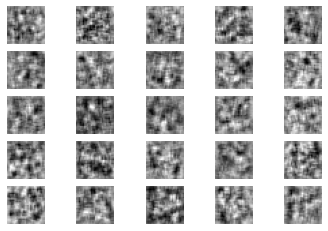

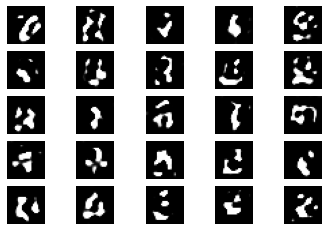

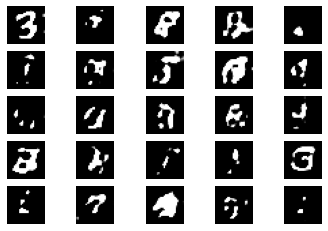

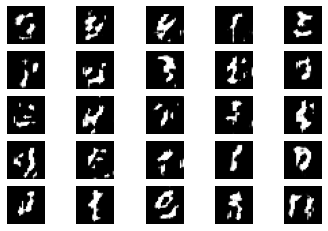

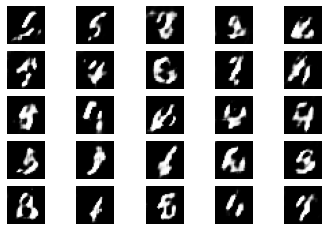

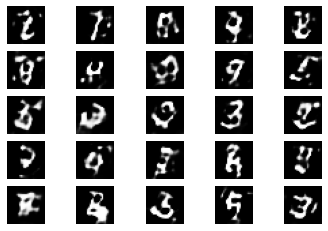

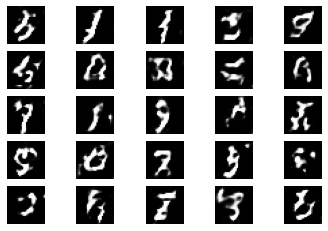

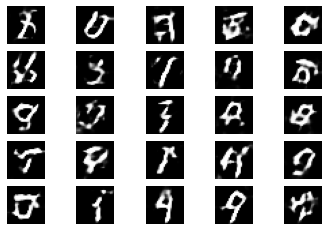

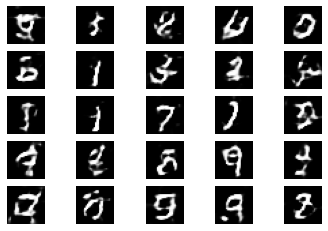

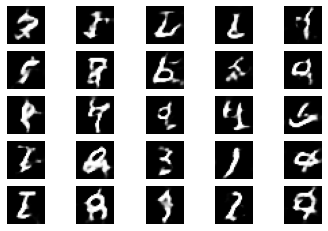

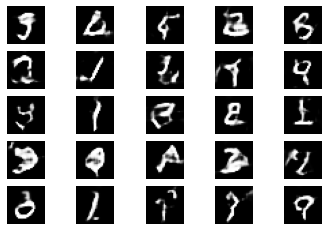

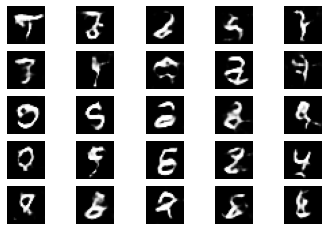

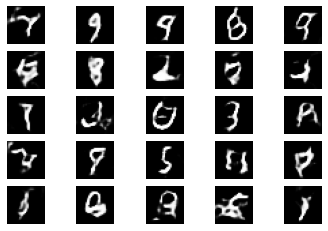

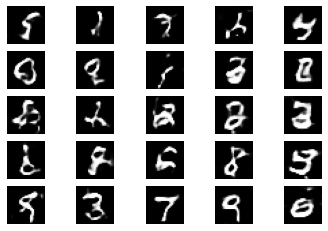

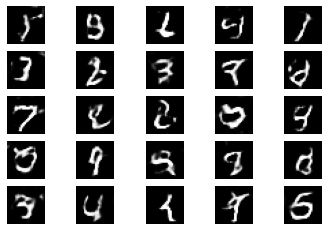

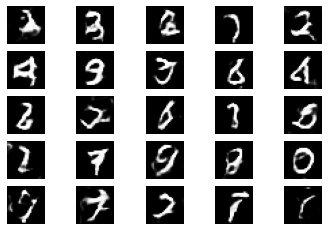

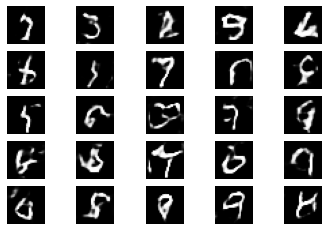

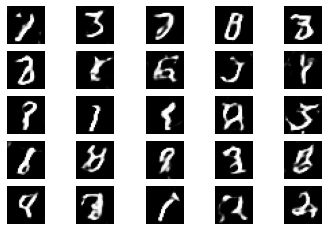

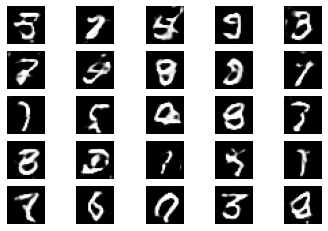

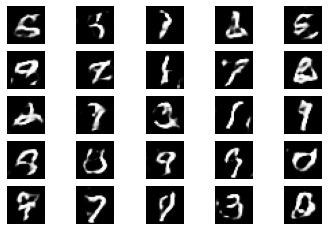

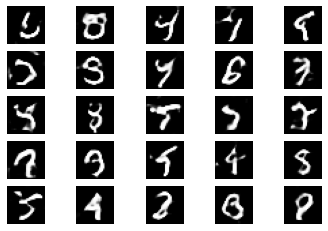

In [14]:
# 4,000번 반복되고(+1을 하는 것에 주의), 배치 크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)

In [15]:
# Epoch 4000까지 진행했을 때의 결과입니다. 
# 점점 숫자에 가까운 형태가 만들어 집니다. 
# 생성된 이미지들은 gan_images 폴더에 저장됩니다.